<a href="https://www.kaggle.com/code/arihant18/covid-19-detection?scriptVersionId=182423045" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
import os
from tensorflow.keras.utils import image_dataset_from_directory
import keras
from keras.applications import ResNet50
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
from keras import Model

2024-06-09 16:25:35.046159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 16:25:35.046299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 16:25:35.326736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train='/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/'
test ='/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/'

In [3]:
train_ds =image_dataset_from_directory(train,
                                       batch_size=148
                                      )
test_ds =image_dataset_from_directory(test,
                                      batch_size=40
                                      )

Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [4]:
single_batch = train_ds.as_numpy_iterator().next()
train_x, train_y = single_batch[0]/255, single_batch[1]
print(train_x.shape, train_y.shape)

single_batch = test_ds.as_numpy_iterator().next()
test_x, test_y = single_batch[0]/255, single_batch[1]
print(test_x.shape, test_y.shape)

(148, 256, 256, 3) (148,)
(40, 256, 256, 3) (40,)


In [5]:
label=os.listdir(train)
label

['PNEUMONIA', 'NORMAL']

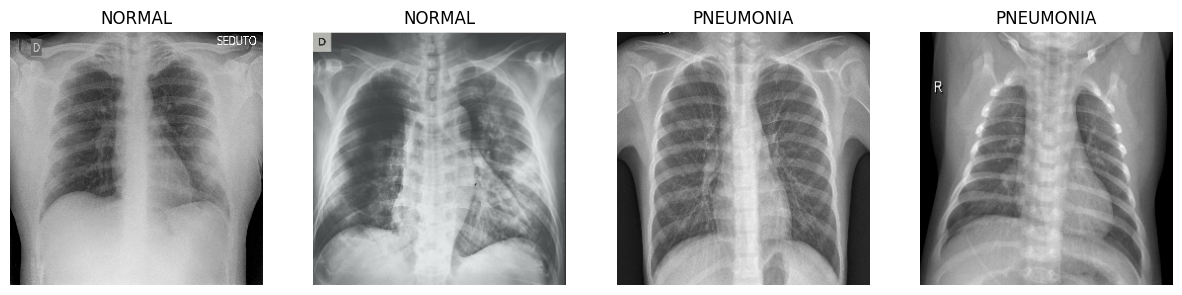

In [6]:
fig, ax = plt.subplots(1,4, figsize=(15,15))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(train_x[i])
    ax[i].set_title(label[train_y[i]])

In [7]:
ResNet = ResNet50(include_top=False, input_shape=train_x[0].shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
for layer in ResNet.layers:
    layer.trainable = False
print("Number of trainable parameters:",len(ResNet.trainable_variables))

Number of trainable parameters: 0


In [9]:
X = Flatten()(ResNet.output)
output = Dense(1, activation='sigmoid')(X)
model = Model(ResNet.input, output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,718,785 (90.48 MB)

 Trainable params: 131,073 (512.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
adam = keras.optimizers.Adam(0.01)
loss = keras.losses.BinaryCrossentropy()

model.compile(loss=loss, optimizer= adam)

In [11]:
History=model.fit(
            train_x, 
            train_y, 
            batch_size=64, 
            epochs = 15,
            validation_data = (test_x, test_y)         
                 ).history

Epoch 1/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 46s 23s/step - loss: 0.7296

I0000 00:00:1717950383.647145      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - loss: 38.2477 - val_loss: 31.2858
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 37.1086 - val_loss: 0.9874
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 11.0838 - val_loss: 0.9008
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 9.9472 - val_loss: 16.4627
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 14.4283 - val_loss: 15.9162
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 10.3363 - val_loss: 9.8886
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 8.7519 - val_loss: 11.9870
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 9.2966 - val_loss: 3.0592
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 7.8898 - val_loss: 1.3067
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 3.3889 - val_loss: 4.8732
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 1.8038 - val_loss: 4.2326
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 5.4172 - val_loss:

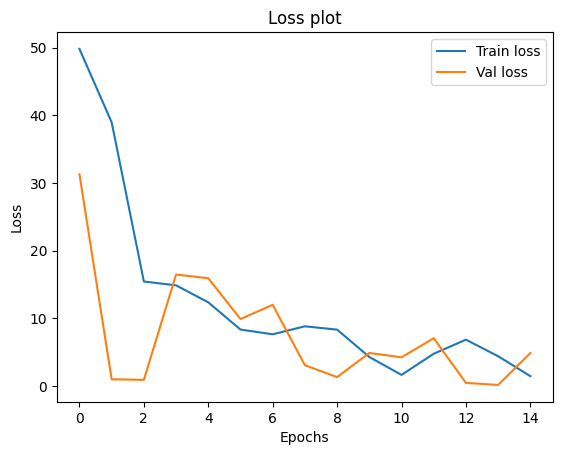

In [12]:
plt.title('Loss plot')
plt.plot(History['loss'])
plt.plot(History['val_loss'])
plt.legend(['Train loss', 'Val loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs');

In [13]:
y_pred = (model.predict(test_x).reshape(-1,)>=0.5).astype(int)
accuracy = np.sum(test_y==y_pred)/len(y_pred)

print("The model have an accuracy of:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step
The model have an accuracy of: 0.675


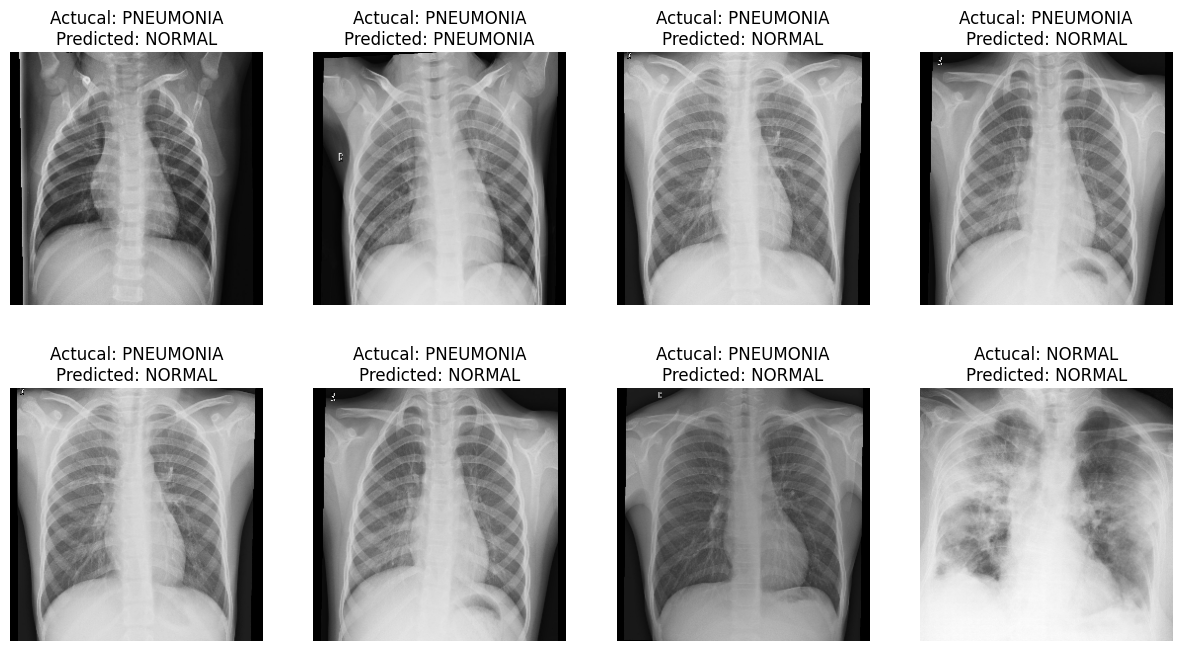

In [14]:
fig,ax= plt.subplots(2,4, figsize=(15, 8))
for i in range(2):
    for j in range(4):
        idx=2*i+j
        ax[i][j].imshow(test_x[idx])
        ax[i][j].axis('off')
        ax[i][j].set_title(f'Actucal: {label[test_y[idx]]}\nPredicted: {label[y_pred[idx]]}')

In [15]:
model.save('/kaggle/working/model.h5')